# Africa Data Inspection

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plot
%matplotlib inline

In [2]:
africa = pd.read_excel('data/Africa_1997-2018_upd-Jul9.xlsx')
africa.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
0,12,ALG1,1,1997-01-01,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Douaouda,36.6725,2.7894,1,www.algeria-watch.org,National,5 January: Beheading of 5 citizens in Douaouda...,5,1524054024
1,12,ALG2,2,1997-01-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Hassasna,36.1333,0.8833,1,www.algeria-watch.org,National,Two citizens were beheaded in Hassasna.,2,1524054024
2,12,ALG3,3,1997-01-03,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Algiers,36.7525,3.0420,3,www.algeria-watch.org,National,Two citizens were killed in a raid on the vill...,2,1524054024
3,12,ALG4,4,1997-01-04,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Blida,36.4686,2.8289,1,www.algeria-watch.org,National,4 January: 16 citizens were murdered in the vi...,16,1524054024
4,12,ALG5,5,1997-01-05,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Douaouda,36.6725,2.7894,1,www.algeria-watch.org,National,5 January: Killing of 18 citizens in the Olivi...,18,1524054024


In [3]:
africa = africa.loc[africa['FATALITIES'] < 100]
# len(africa.YEAR.unique())
africa.FATALITIES.unique()
# africa.loc[africa['FATALITIES'] == 25000].NOTES[22159]

array([ 5,  2, 16, 18,  4, 23,  7, 20,  0,  1, 14, 15, 43, 54,  6, 19, 30,
        9, 35,  8, 28, 25, 33, 32, 13, 50, 12, 80, 42, 21, 29, 10, 48, 22,
       27, 11, 36, 39, 38, 60, 24, 64, 70, 85, 47, 37, 26, 31, 34, 78, 62,
       17,  3, 52, 81, 40, 45, 53, 49, 73, 68, 88, 72, 67, 51, 93, 90, 41,
       57, 76, 66, 44, 83, 74, 63, 59, 65, 84, 94, 91, 56, 71, 58, 86, 87,
       46, 61, 69, 55, 82, 75, 96, 79, 98, 99, 95, 77, 89, 97, 92])

In [4]:
africa_map = gp.read_file('data/Africa_SHP/Africa.shp')
len(africa_map['COUNTRY'].unique())

52

In [5]:
africa_map.head()

,ID,CODE,COUNTRY,geometry
0,1,ALG,Algeria,"POLYGON ((-5.7636199999979 25.58624999999302, ..."
1,2,ANG,Angola,"POLYGON ((13.36632442474365 -8.32172966003418,..."
2,3,ANG,Angola,POLYGON ((12.80576000000292 -4.806490000002668...
3,4,ANG,Angola,POLYGON ((11.76834011077881 -16.79932975769043...
4,5,ANG,Angola,POLYGON ((12.89840030670166 -5.988018989562988...


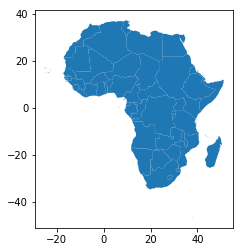

In [6]:
africa_map.plot()

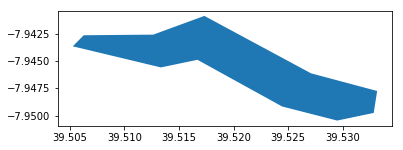

In [7]:
africa_map[732:733].plot()

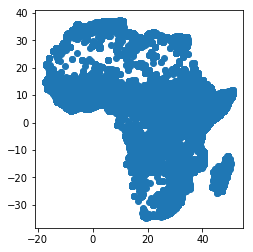

In [8]:
from shapely.geometry import Point

africa['Coordinates'] = list(zip(africa.LONGITUDE, africa.LATITUDE))
africa['Coordinates'] = africa['Coordinates'].apply(Point)
points = gp.GeoDataFrame(africa, geometry='Coordinates')

points.plot()

In [9]:
from fiona.crs import from_epsg

points.crs = from_epsg(4326)
africa_map.crs = from_epsg(4326)
points.crs == africa_map.crs

True

In [10]:
join = gp.sjoin(points, africa_map, how="inner", op="within")
join.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,Coordinates,index_right,ID,CODE,COUNTRY_right
0,12,ALG1,1,1997-01-01,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,5 January: Beheading of 5 citizens in Douaouda...,5,1524054024,POINT (2.7894 36.6725),0,1,ALG,Algeria
1,12,ALG2,2,1997-01-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,Two citizens were beheaded in Hassasna.,2,1524054024,POINT (0.8833 36.1333),0,1,ALG,Algeria
2,12,ALG3,3,1997-01-03,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,Two citizens were killed in a raid on the vill...,2,1524054024,POINT (3.042 36.7525),0,1,ALG,Algeria
3,12,ALG4,4,1997-01-04,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,4 January: 16 citizens were murdered in the vi...,16,1524054024,POINT (2.8289 36.4686),0,1,ALG,Algeria
4,12,ALG5,5,1997-01-05,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,5 January: Killing of 18 citizens in the Olivi...,18,1524054024,POINT (2.7894 36.6725),0,1,ALG,Algeria


In [11]:
join.COUNTRY_right.isna().sum()

0

In [12]:
join[20000:20003]

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,Coordinates,index_right,ID,CODE,COUNTRY_right
68321,566,NIG3033,3033,2011-03-18,2011,1,Violence against civilians,Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai...,NaN,3,...,Agence France Presse,International,Gunmen on Friday shot dead a Muslim cleric in ...,1,1524053967,POINT (13.1603 11.8464),625,626,NIR,Nigeria
68322,566,NIG3034,3034,2011-03-18,2011,1,Violence against civilians,Unidentified Armed Group (Nigeria),NaN,3,...,Vanguard (Lagos),Subnational,"Gunmen of an opposition party (likely AC, but ...",0,1518765563,POINT (7.985 6.7918),625,626,NIR,Nigeria
68323,566,NIG3035,3035,2011-03-20,2011,1,Remote violence,Fulani Ethnic Militia (Nigeria),NaN,4,...,Reuters,International,Two men were killed in the central Nigerian ci...,2,1524053967,POINT (8.892099999999999 9.9285),625,626,NIR,Nigeria


/Users/adamhunter/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


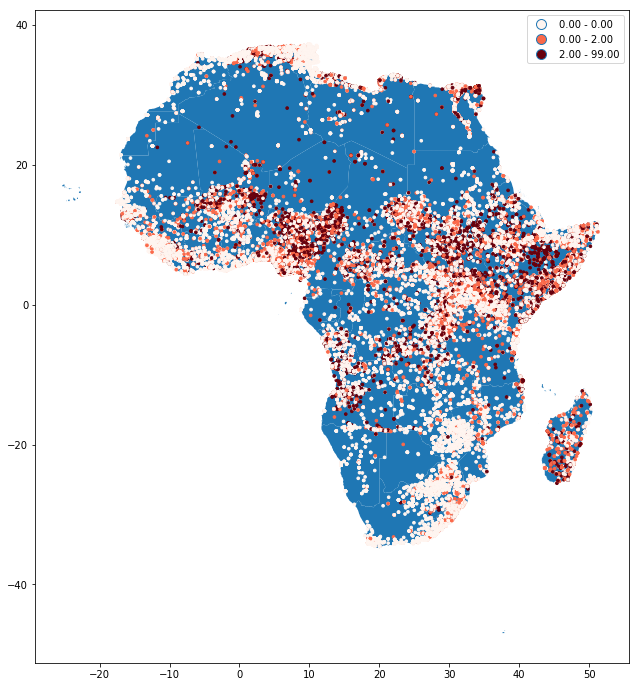

In [13]:
f, ax = plot.subplots(1)

plot_africa = africa_map.plot(ax=ax)
plot_points = join.plot(ax=ax, column='FATALITIES', cmap='Reds', scheme='quantiles', markersize=7, legend=True)

f.set_size_inches(12,12)

plot.show()

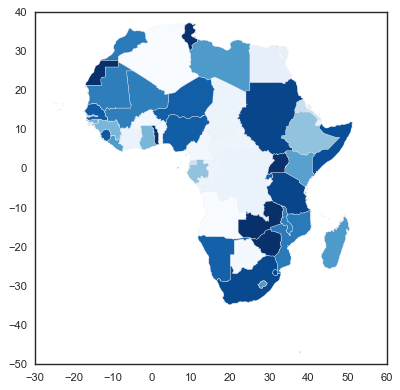

In [38]:
plot.style.use('seaborn-white')
africa_map.plot(cmap="Blues")

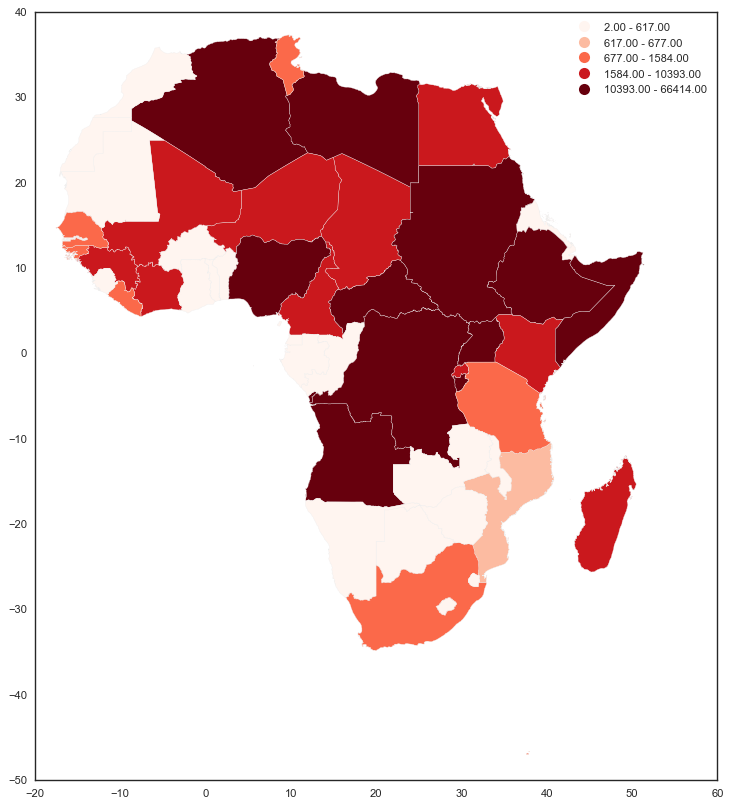

In [78]:
fatals = join[['COUNTRY_right', 'FATALITIES']].groupby('COUNTRY_right').sum()
fatals = gp.GeoDataFrame(fatals.merge(africa_map, left_on='COUNTRY_right', right_on='COUNTRY'))

f, ax = plot.subplots(1)
f.set_size_inches(12,12)
fatals.plot(ax=ax, column='FATALITIES', cmap='Reds', legend=True, scheme='quantiles')